<a href="https://colab.research.google.com/github/Rammani10Biswas/DS-project/blob/test-branch/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#step 1
df = pd.read_csv("/content/data.csv")  # Replace 'data.csv' with your actual file path if different
print("Initial data shape:", df.shape)

Initial data shape: (6819, 96)


In [ ]:
# Check missing values
print("\nMissing values per column:\n", df.isnull().sum())

# Strategy: Fill numeric with median, categorical with mode
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

print("\nMissing values after imputation:\n", df.isnull().sum())


# Remove Duplicates

duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")
df = df.drop_duplicates()
print("Data shape after removing duplicates:", df.shape)


# Detect and Remove Outliers (Z-score method)


def remove_outliers_zscore(data, threshold=3):
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    z_scores = np.abs((data[numeric_cols] - data[numeric_cols].mean()) / data[numeric_cols].std())
    filtered_entries = (z_scores < threshold).all(axis=1)
    return data[filtered_entries]

df = remove_outliers_zscore(df)
print("Data shape after outlier removal:", df.shape)


# Encode Categorical Variables


categorical_cols = df.select_dtypes(include=['object']).columns
print("\nCategorical columns to encode:", list(categorical_cols))

le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])


# Normalize Numeric Features


scaler = StandardScaler()
numerical_cols = df.select_dtypes(include=[np.number]).columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


print("\nFinal cleaned and normalized data shape:", df.shape)
print(df.head())


Missing values per column:
 Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64

Missing values after imputation:
 Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation af

In [ ]:
#step 2
### 1. Financial Health Monitoring System ###
class FinancialHealthMonitor:
    def __init__(self, data):
        self.data = data
        self.model = None
        self.scaler = StandardScaler()
        self.thresholds = {
            'ROA(C)': 0.02,  # Minimum acceptable ROA
            'Debt ratio %': 0.6,  # Maximum debt ratio
            'Net Income to Total Assets': 0.03,  # Minimum net income ratio
            'Operating Profit Rate': 0.1  # Minimum operating profit margin
        }

    def preprocess_data(self):
        X = self.data.drop('Bankrupt?', axis=1)
        y = self.data['Bankrupt?']
        return train_test_split(X, y, test_size=0.2, random_state=42)

    def train_model(self):
        X_train, X_test, y_train, y_test = self.preprocess_data()
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        self.model = RandomForestClassifier(
            n_estimators=100,
            class_weight='balanced',
            random_state=42
        )
        self.model.fit(X_train_scaled, y_train)

        # Evaluate
        y_pred = self.model.predict(X_test_scaled)


        print("Model Evaluation:")
        print(classification_report(y_test, y_pred))


    def calculate_financial_metrics(self, company_data):
        """Calculate key financial ratios for a company"""
        metrics = {
            'ROA(C)': company_data['ROA(C) before interest and depreciation before interest'],
            'Debt_ratio': company_data['Debt ratio %'],
            'Net_Income_ratio': company_data['Net Income to Total Assets'],
            'Operating_margin': company_data['Operating Profit Rate'],
            'Current_ratio': company_data['Current Ratio'],
            'Cash_flow_ratio': company_data['Cash Flow to Sales']
        }
        return metrics

    def generate_health_report(self, company_data):
        """Generate a financial health report with warnings"""
        metrics = self.calculate_financial_metrics(company_data)
        report = []
        warnings = []

        # Bankruptcy probability
        proba = self.model.predict_proba(
            self.scaler.transform(company_data.values.reshape(1, -1))
        )[0][1]

        report.append(f"Bankruptcy Probability: {proba:.1%}")

        # Threshold checks
        for metric, value in metrics.items():
            if metric in self.thresholds:
                threshold = self.thresholds[metric]
                if 'Debt' in metric and value > threshold:
                    warnings.append(f"High {metric.replace('_', ' ')} ({value:.1%} > {threshold:.0%})")
                elif 'Debt' not in metric and value < threshold:
                    warnings.append(f"Low {metric.replace('_', ' ')} ({value:.1%} < {threshold:.0%})")

        # Add liquidity check
        if metrics['Current_ratio'] < 1:
            warnings.append(f"Low liquidity (Current Ratio: {metrics['Current_ratio']:.1f} < 1)")

        # Add cash flow warning
        if metrics['Cash_flow_ratio'] < 0.05:
            warnings.append(f"Low cash flow (Cash Flow to Sales: {metrics['Cash_flow_ratio']:.1%})")

        return report, warnings

# Initialize and train the monitor
monitor = FinancialHealthMonitor(df)
monitor.train_model()

Model Evaluation:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       958

    accuracy                           1.00       958
   macro avg       1.00      1.00      1.00       958
weighted avg       1.00      1.00      1.00       958



In [ ]:
#step 3
 # Encode Categorical Features

cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])


# Date Feature Extraction
if 'signup_date' in df.columns:
    df['signup_date'] = pd.to_datetime(df['signup_date'])
    df['signup_year'] = df['signup_date'].dt.year
    df['signup_month'] = df['signup_date'].dt.month
    df['signup_weekday'] = df['signup_date'].dt.weekday
    df.drop('signup_date', axis=1, inplace=True)


# Derived Features Based on Business Logic

if {'total_orders', 'total_spent'}.issubset(df.columns):
    df['avg_order_value'] = df['total_spent'] / (df['total_orders'] + 1e-5)


if 'signup_date' in df.columns and 'last_order_date' in df.columns:
    df['signup_date'] = pd.to_datetime(df['signup_date'])
    df['last_order_date'] = pd.to_datetime(df['last_order_date'])
    df['customer_tenure'] = (df['last_order_date'] - df['signup_date']).dt.days // 30
    df.drop(['signup_date', 'last_order_date'], axis=1, inplace=True)


# Normalize/Scale Numerical Features

num_cols = df.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


print("\nFeature-engineered data preview:")
print(df.head())


Feature-engineered data preview:
    Bankrupt?   ROA(C) before interest and depreciation before interest  \
6         0.0                                          -2.512161          
7         0.0                                           0.000074          
8         0.0                                          -0.424367          
9         0.0                                          -0.271068          
10        0.0                                          -0.553681          

     ROA(A) before interest and % after tax  \
6                                 -2.461752   
7                                  0.168173   
8                                 -0.373383   
9                                 -0.252020   
10                                 0.097187   

     ROA(B) before interest and depreciation after tax  \
6                                           -2.634309    
7                                            0.039263    
8                                           -0.304249    


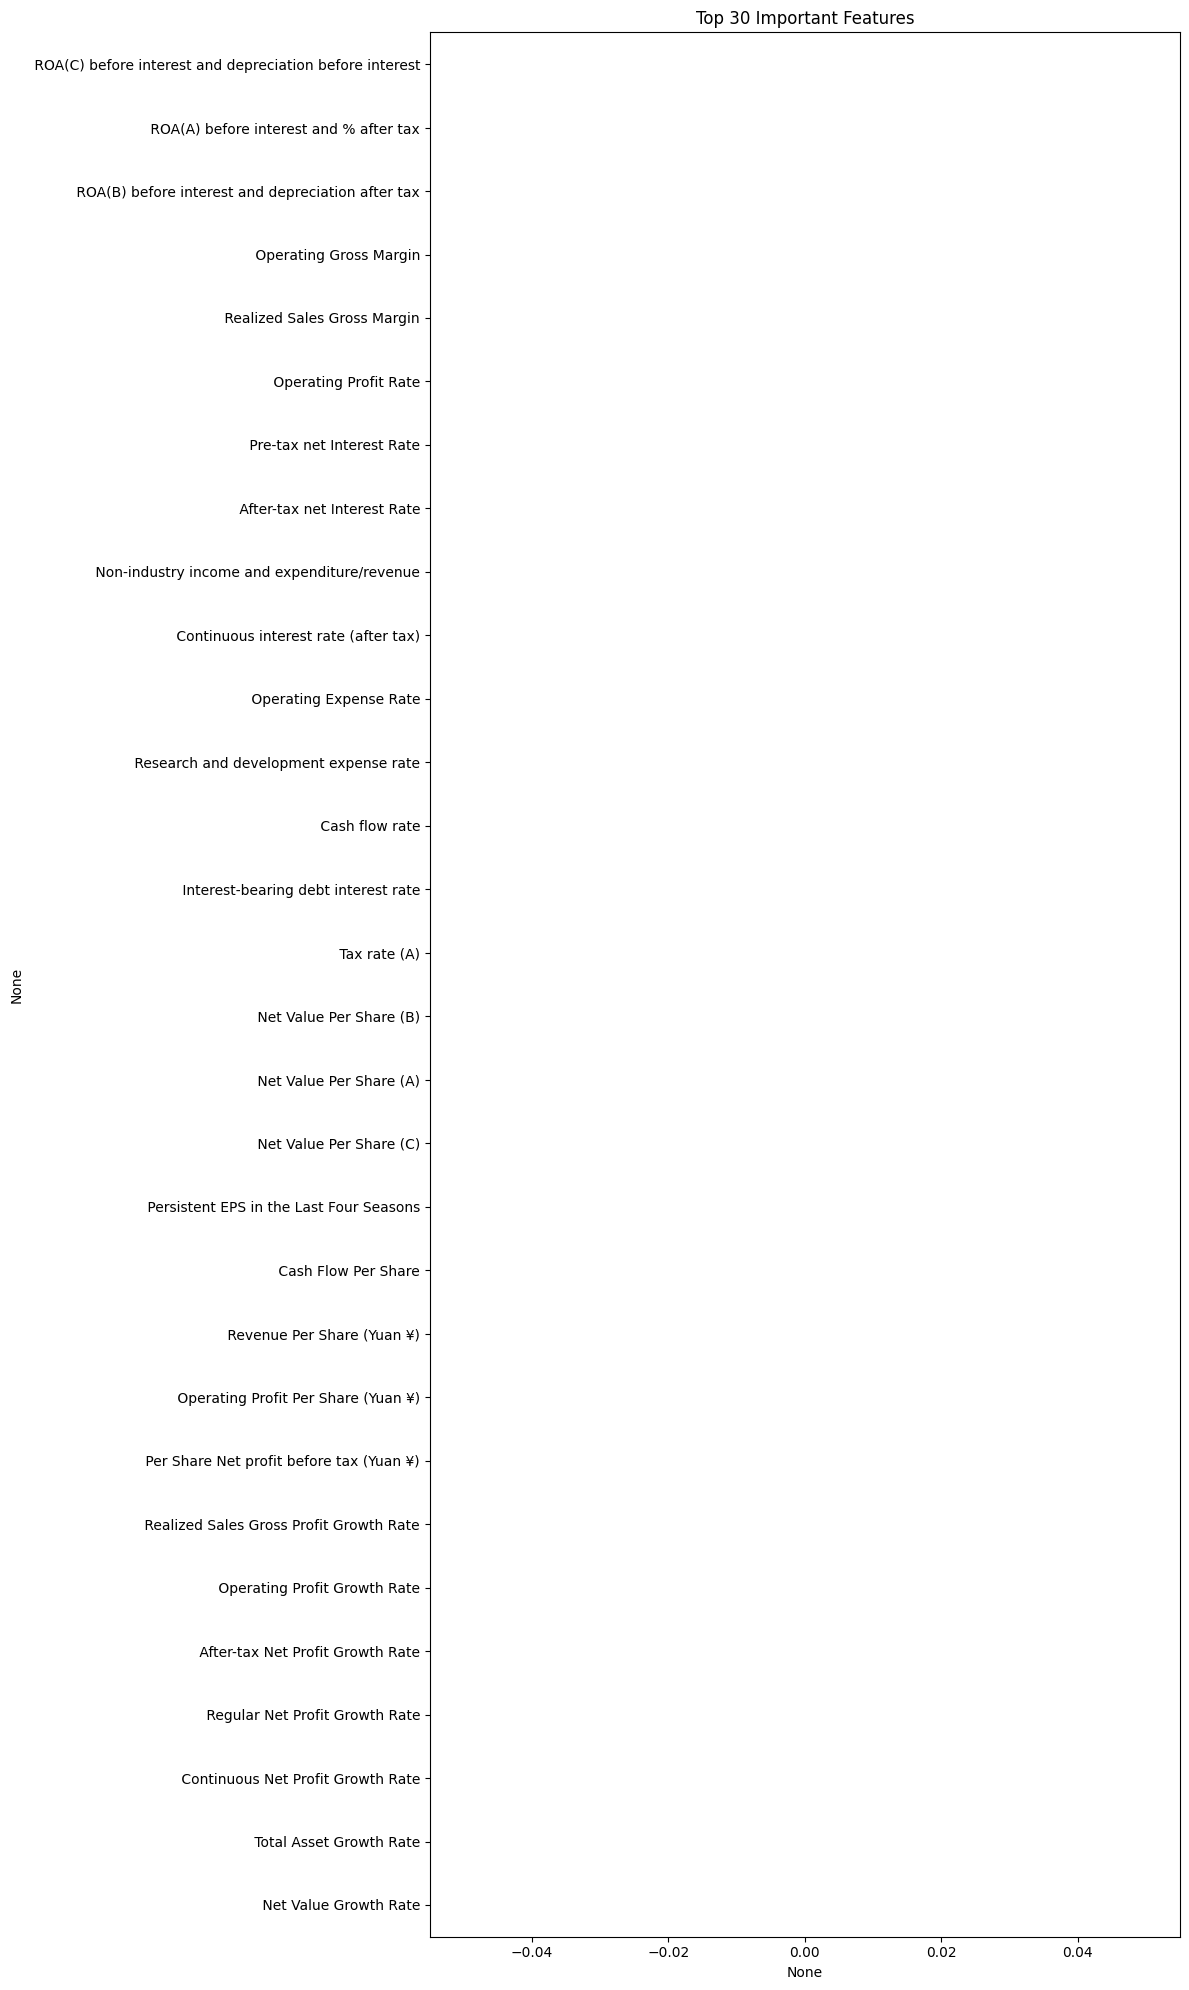

In [ ]:
# step 4
# Separate features and target
X = df.drop('Bankrupt?', axis=1)
y = df['Bankrupt?']

# Feature importance using Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Plot feature importance
feature_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(12, 20))
sns.barplot(x=feature_imp[:30], y=feature_imp.index[:30])
plt.title('Top 30 Important Features')
plt.tight_layout()
plt.show()


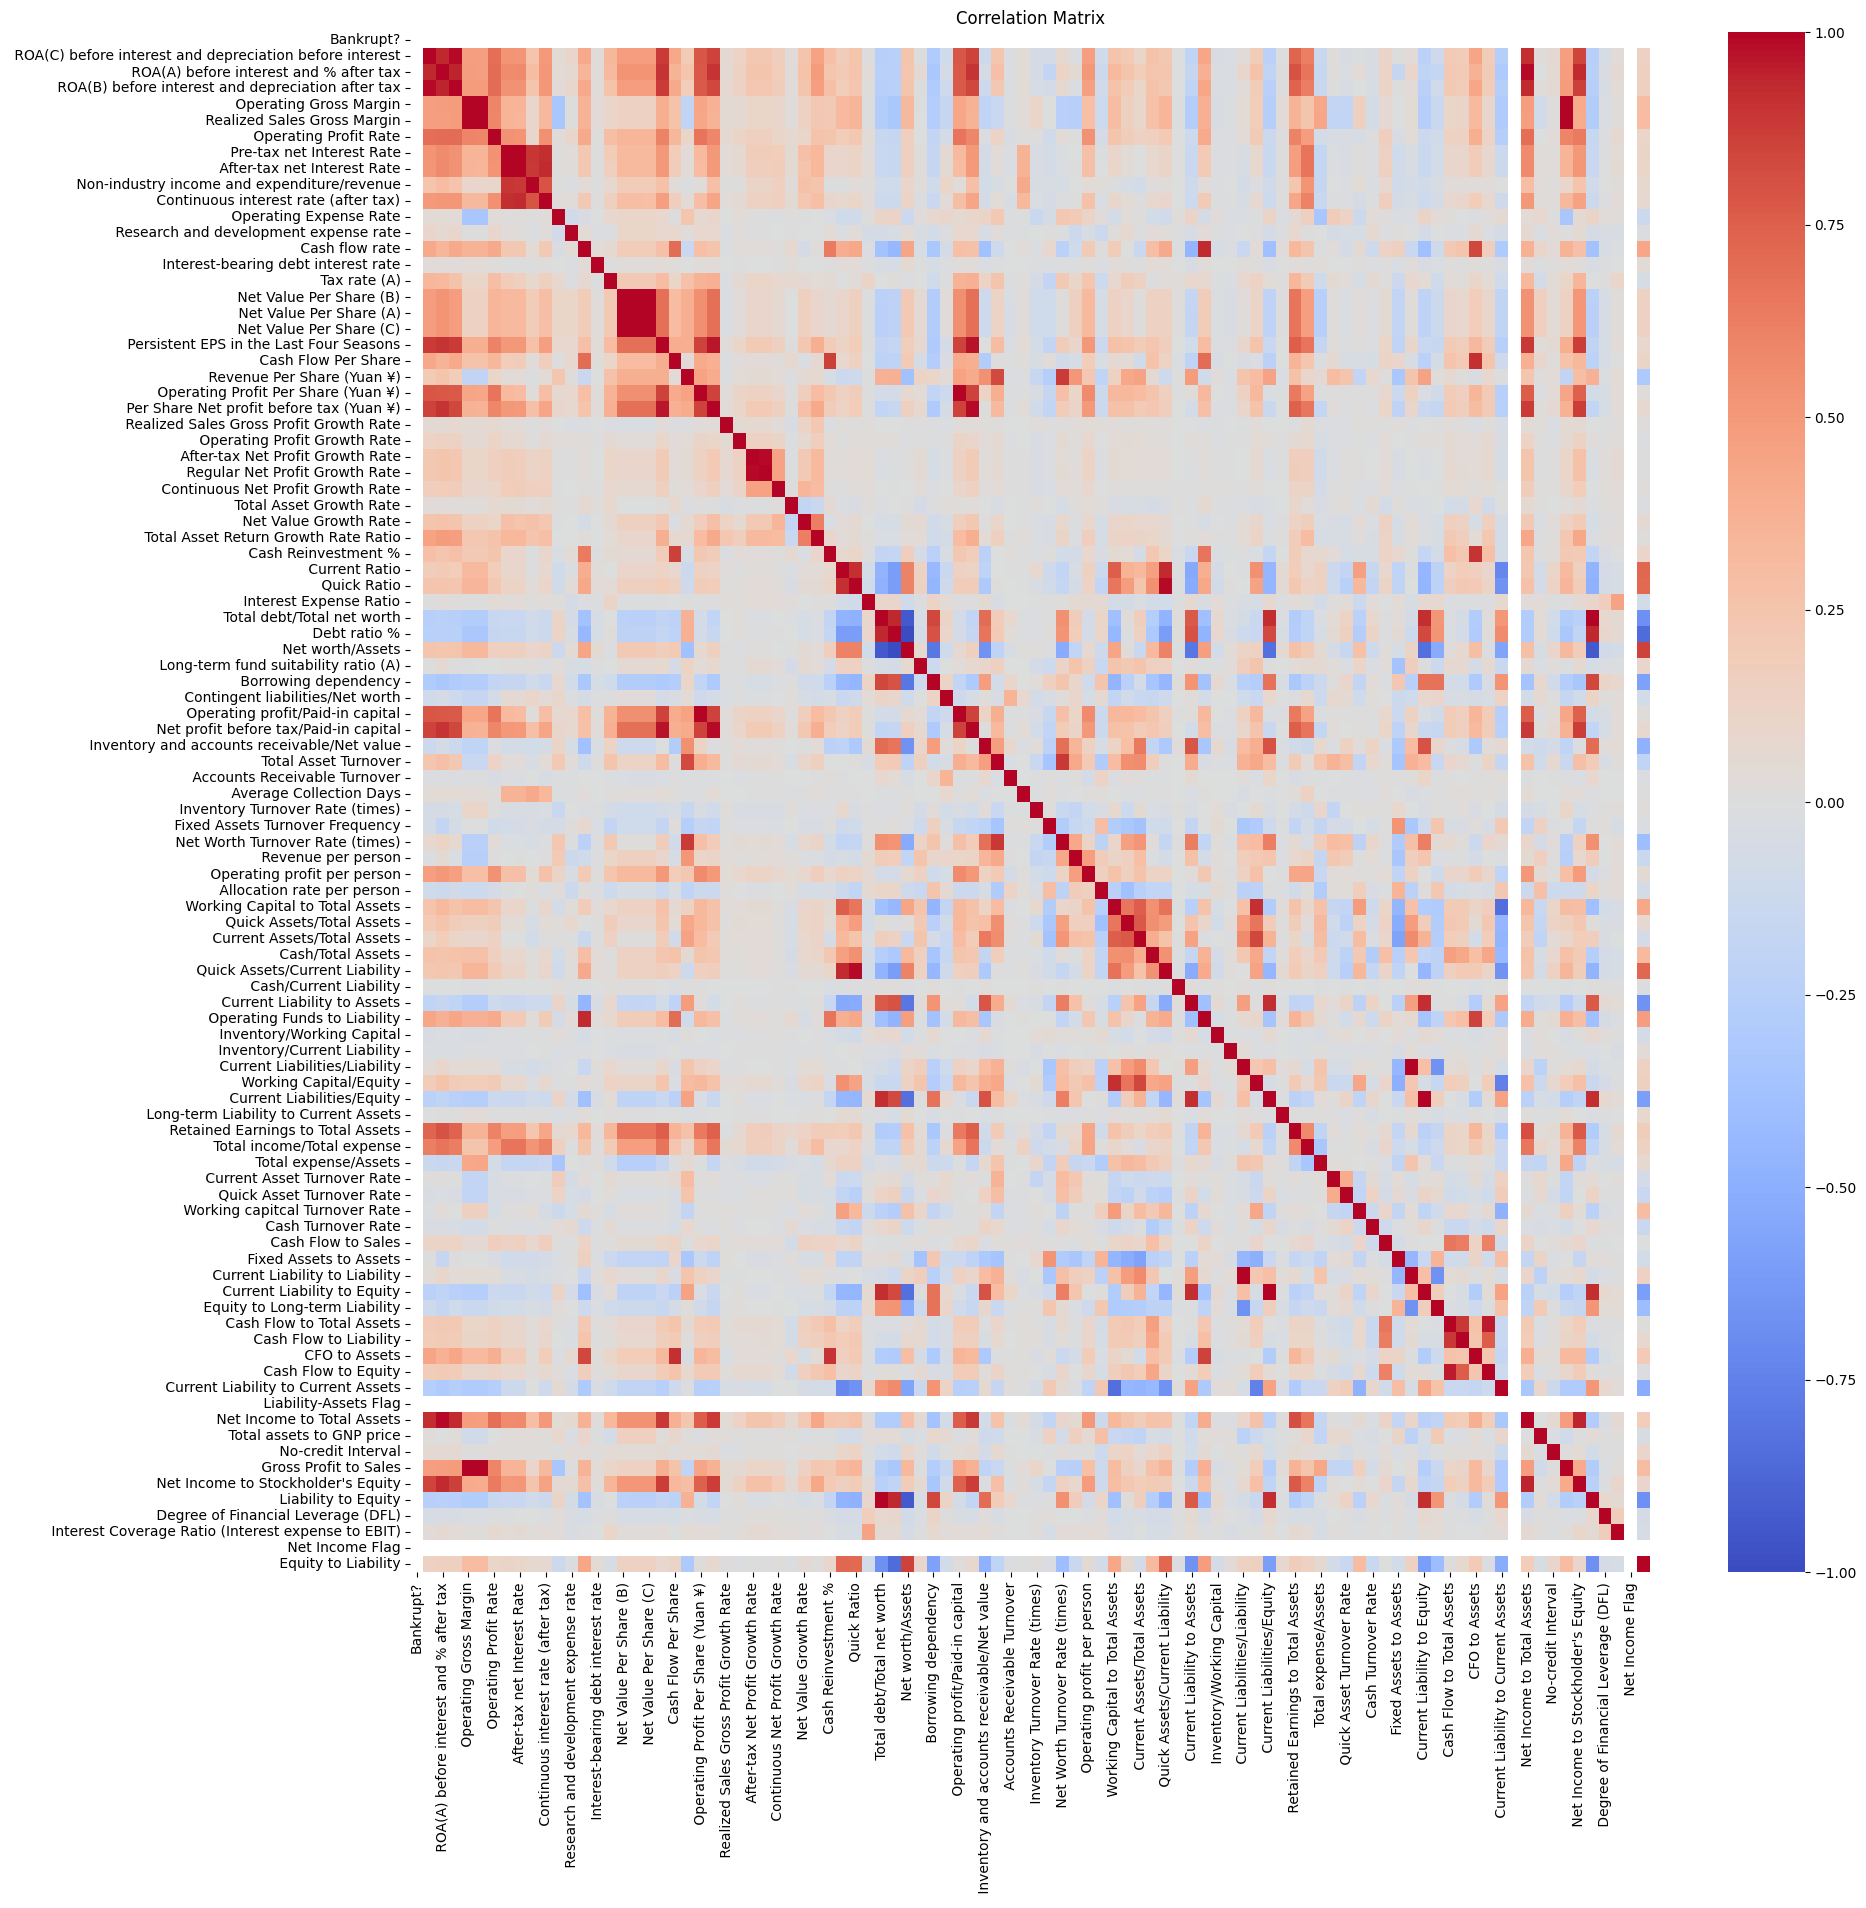

Bankrupt?                                                  NaN
 ROA(C) before interest and depreciation before interest   NaN
 ROA(A) before interest and % after tax                    NaN
 ROA(B) before interest and depreciation after tax         NaN
 Operating Gross Margin                                    NaN
 Realized Sales Gross Margin                               NaN
 Operating Profit Rate                                     NaN
 Pre-tax net Interest Rate                                 NaN
 After-tax net Interest Rate                               NaN
 Non-industry income and expenditure/revenue               NaN
Name: Bankrupt?, dtype: float64
Net Income to Total Assets                           NaN
Total assets to GNP price                            NaN
No-credit Interval                                   NaN
Gross Profit to Sales                                NaN
Net Income to Stockholder's Equity                   NaN
Liability to Equity                                  

In [ ]:
# Correlation analysis
corr_matrix = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Top correlated features with bankruptcy
bankrupt_corr = corr_matrix['Bankrupt?'].sort_values(ascending=False)
print(bankrupt_corr.head(10))
print(bankrupt_corr.tail(10))

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection
selector = SelectKBest(f_classif, k=30)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Train model
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train_selected, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:107: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
# Evaluate
y_pred = rf.predict(X_test_selected)


print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))



              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1437

    accuracy                           1.00      1437
   macro avg       1.00      1.00      1.00      1437
weighted avg       1.00      1.00      1.00      1437

[[1437]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
